In [1]:
from __future__ import division, print_function
%matplotlib inline
from utils import *
from keras.layers.merge import dot, add, concatenate
from pandas_summary import DataFrameSummary
import seaborn as sns
import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Using TensorFlow backend.


# StuffMyFridge: A Grocery Product Recommender

The goal of this notebook is to build a grocery product recommendation system for users of the Instacart app. 
Instacart is a company that deliveres groceries from local stores.
We will use “The Instacart Online Grocery Shopping Dataset 2017”, which can be found in https://www.instacart.com/datasets/grocery-shopping-2017.

Here is the data description: 

`orders` (3.4m rows, 206k users, 109 MB):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows, 2.2 MB):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows, 2.6 kB):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`departments` (21 rows, 270 bytes):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders, 577.6 MB)
* `"train"`: training data supplied to participants (~131k orders, 24.7 Mb)

## Set up data

Read data:

In [3]:
order_products_prior_df =  pd.read_csv('data/order_products__prior.csv', engine='c',  
                                       dtype={'order_id': np.int32, 'product_id': np.int32,
                                              'add_to_cart_order': np.int16, 'reordered': np.int8})

order_products_train_df = pd.read_csv('data/order_products__train.csv', engine='c',  
                                      dtype={'order_id': np.int32, 'product_id': np.int32, 
                                      'add_to_cart_order': np.int16, 'reordered': np.int8})

orders_df = pd.read_csv('data/orders.csv', engine='c', 
                        dtype={'order_id': np.int32, 'user_id': np.int32, 'order_number': np.int32,
                       'order_dow': np.int8, 'order_hour_of_day': np.int8, 'days_since_prior_order': np.float16})

products_df = pd.read_csv("data/products.csv", engine='c')

aisles_df = pd.read_csv("data/aisles.csv", engine='c')

departments_df = pd.read_csv("data/departments.csv", engine='c')

Define dicts to go from ids to names and vice-versa

In [4]:
aisles_id2name = pd.Series(aisles_df.aisle.values, index=aisles_df.aisle_id).to_dict()
prodid2aisle = pd.Series(products_df.aisle_id.values, index=products_df.product_id).to_dict()

Useful info about dataset:

Total number of products: 49677
Total number of users: 206209
Total number of orders placed: 3421083
Total number of products ordered: 32434489
Average number of products per order: 9
Number of products per aisle (top 10):


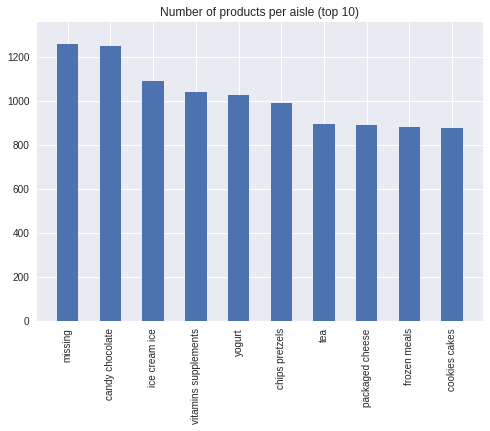

In [110]:
print('Total number of products: {}'.format(order_products_prior_df.product_id.unique().shape[0]))
print('Total number of users: {}'.format(orders_df.user_id.unique().shape[0]))
print('Total number of orders placed: {}'.format(orders_df.shape[0]))
print('Total number of products ordered: {}'.format(order_products_prior_df.shape[0]))
print('Average number of products per order: {}'.format(round(order_products_prior_df.shape[0]/orders_df.shape[0])))

prod_aisle_dist = products_df.groupby('aisle_id')['product_name'].count().sort_values(ascending=False)
num_prods_per_aisle_sorted = list(zip(map(aisles_id2name.get, prod_aisle_dist.index), prod_aisle_dist.values ))
print('Number of products per aisle (top 10):')
dic = OrderedDict({x:y for x,y in num_prods_per_aisle_sorted[:10]})

X = np.arange(len(dic))
plt.bar(X, dic.values(), align='center', width=0.5)
plt.xticks(X, dic.keys(), rotation = 90)
ymax = max(dic.values()) + 100
plt.ylim(0, ymax)
plt.title('Number of products per aisle (top 10)')
plt.show()

Collect order and product info for each user and merge into a data frame df

In [6]:
df_train = orders_df.merge(order_products_train_df, how = 'inner', on = 'order_id')
df_train = df_train.merge(products_df, how = 'inner', on = 'product_id')
df_train.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [7]:
df_prior = orders_df.merge(order_products_prior_df, how = 'inner', on = 'order_id')
df_prior = df_prior.merge(products_df, how = 'inner', on = 'product_id')
df_prior.sort_values(['user_id', 'order_number'], axis=0, inplace=True)

In [8]:
df = pd.concat([df_prior, df_train])

In [9]:
#fillna
df.fillna(0,axis=0, inplace=True)
df.drop('eval_set', axis=1, inplace = True)
df.reset_index(drop = True, inplace = True)
del df_train, df_prior

In [10]:
sample=int(1e5)
df = df.iloc[:sample]

In [111]:
df.head(3);

## Product Rating per User

Users did not rate products but we can figure how often a user bought a given product and then use this as a proxy for a rating score. 

In [13]:
#Update product and user ids so that they are contiguous integers, which we want when using embeddings.
g=df.groupby(['user_id','product_name','product_id'])

#create prod_rating df and add a product_count feature (i.e. how many times has the user reordered the product)
prod_ratings = g['reordered'].count().reset_index()
prod_ratings.columns = ['user_id', 'product_name', 'product_id', 'product_count']

In [14]:
users = prod_ratings.user_id.unique()
prods = prod_ratings.product_id.unique()

userid2idx = {o:i for i,o in enumerate(users)}
prodid2idx = {o:i for i,o in enumerate(prods)}

prod_ratings.product_id = prod_ratings.product_id.apply(lambda x: prodid2idx[x])
prod_ratings.user_id = prod_ratings.user_id.apply(lambda x: userid2idx[x])

In [15]:
#number of users and products in sample
n_users = prod_ratings.user_id.nunique()
n_prods = prod_ratings.product_id.nunique()
print(n_users, n_prods)

667 12469


Here is a function that plots the product count distribution for a given user (top 10)

In [106]:
def product_dist(u_id):
    '''Plot the product count distribution for a given user (top 10)'''
    user_data = prod_ratings[prod_ratings.user_id==u_id]
    sorted_tuple = sorted(zip(user_data.product_name, user_data.product_count), key =itemgetter(1), reverse = True)
    user_dict = OrderedDict(sorted_tuple[:10])
    x = np.arange(len(user_dict))
    plt.bar(x, user_dict.values(), align='center', width=0.5)
    plt.xticks(x, user_dict.keys(), rotation = 90)
    ymax = max(user_dict.values()) + 1
    plt.ylim(0, ymax)
    plt.title('Product count distribution for user 0 (top 10 only)')
    plt.show()

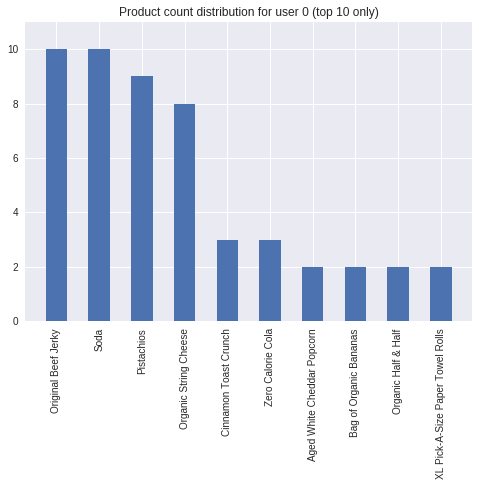

In [107]:
product_dist(0)

Define star (1-5) and then apply it to the 'product_count' column to get 'product_rating'.

In [152]:
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import MinMaxScaler

def round_rating(number):
    """Round a number to the closest half integer"""
    return np.round(number * 2) / 2

mapper = DataFrameMapper([('product_count', MinMaxScaler())], df_out=True)

#apply the mapper to each user and concatenate results
dfs = [np.round(mapper.fit_transform(prod_ratings[prod_ratings.user_id==u].copy()), 1) for u in range(n_users)]

prod_ratings['product_score'] = pd.concat(dfs).reset_index(drop=True)*4 + 1
prod_ratings['product_score'] = round_rating(prod_ratings['product_score'])#.astype(int)
#print(prod_ratings.shape)
prod_ratings.head(20)

/home/cyrfar/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


,user_id,product_name,product_id,product_count,product_score
0,0,0% Greek Strained Yogurt,0,1,1.0
1,0,Aged White Cheddar Popcorn,1,2,1.5
2,0,Bag of Organic Bananas,2,2,1.5
3,0,Bartlett Pears,3,1,1.0
4,0,Cinnamon Toast Crunch,4,3,2.0
5,0,Creamy Almond Butter,5,1,1.0
6,0,Honeycrisp Apples,6,1,1.0
7,0,Milk Chocolate Almonds,7,1,1.0
8,0,Organic Fuji Apples,8,1,1.0
9,0,Organic Half & Half,9,2,1.5


Let us create a crosstab from the top 10 users and the top 10 products

In [21]:
g=prod_ratings.groupby('user_id')['product_score'].count()
topUsers=g.sort_values(ascending=False)[:10]

g=prod_ratings.groupby('product_name')['product_score'].count()
topProds=g.sort_values(ascending=False)[:10]

top_r = prod_ratings.join(topUsers, rsuffix='_r', how='inner', on='user_id')
top_r = top_r.join(topProds, rsuffix='_r', how='inner', on='product_name')

In [22]:
pd.crosstab(top_r.user_id, top_r.product_name, top_r.product_score, aggfunc=np.sum)

product_name,Bag of Organic Bananas,Banana,Large Lemon,Limes,Organic Avocado,Organic Baby Spinach,Organic Blueberries,Organic Hass Avocado,Organic Strawberries,Strawberries
user_id,,,,,,,,,,
53,NaN,2.5,2.5,1.5,2.5,1.5,NaN,NaN,1.0,1.0
132,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,2.0,1.0,1.0,2.0,NaN,1.0,1.0,2.0,2.0,1.5
172,3.5,2.0,2.0,1.5,NaN,4.5,NaN,NaN,4.0,2.5
209,NaN,4.0,1.0,1.0,1.0,2.0,1.0,2.0,1.5,1.5
235,1.0,1.5,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
289,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
326,NaN,5.0,NaN,1.0,1.0,NaN,NaN,1.0,2.0,NaN
465,2.0,4.5,NaN,1.0,2.0,1.5,2.0,NaN,3.5,NaN


Randomly split into training and validation.

##  Simple dot product model using embeddings in Keras

In [105]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [122]:
np.random.seed = 42

#split dataset into trn and val
msk = np.random.rand(len(prod_ratings)) < 0.8
trn = prod_ratings[msk]
val = prod_ratings[~msk]

#number of latent factors 
n_factors = 50

#get embedding inputs
user_in, u = embedding_input('user_in', n_users, n_factors, 10)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 10)

In [123]:
def create_bias(inp, n_in):
    x = Embedding(input_dim=n_in, output_dim=1, input_length=1)(inp)
    return Flatten()(x)

In [124]:
ub = create_bias(user_in, n_users)
pb = create_bias(prod_in, n_prods)

Train on 33379 samples, validate on 8311 samples
Epoch 1/100
33379/33379 [==============================] - 10s - loss: 149.0660 - rmse: 1.3852 - val_loss: 2.3759 - val_rmse: 1.2584
Epoch 2/100
33379/33379 [==============================] - 10s - loss: 2.2458 - rmse: 1.1784 - val_loss: 1.9427 - val_rmse: 1.0690
Epoch 3/100
33379/33379 [==============================] - 10s - loss: 1.8513 - rmse: 0.9926 - val_loss: 1.6190 - val_rmse: 0.9005
Epoch 4/100
33379/33379 [==============================] - 10s - loss: 1.5595 - rmse: 0.8318 - val_loss: 1.3822 - val_rmse: 0.7622
Epoch 5/100
33379/33379 [==============================] - 10s - loss: 1.3470 - rmse: 0.7078 - val_loss: 1.2113 - val_rmse: 0.6640
Epoch 6/100
33379/33379 [==============================] - 9s - loss: 1.1934 - rmse: 0.6249 - val_loss: 1.0894 - val_rmse: 0.6031
Epoch 7/100
33379/33379 [==============================] - 9s - loss: 1.0823 - rmse: 0.5760 - val_loss: 1.0024 - val_rmse: 0.5688
Epoch 8/100
33379/33379 [=========

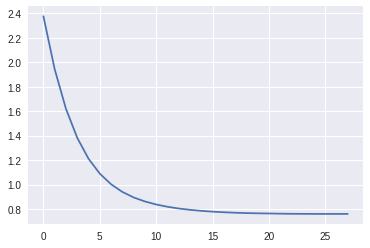

In [125]:
from keras import backend
from keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    '''Define Root Mean Squared Error as our custom metric'''
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

x = dot([u, p], axes=2)
x = Flatten()(x)
x = add([x, ub])
x = add([x, pb])
model = Model([user_in, prod_in], x)
model.compile(Adam(0.001), loss='mse', metrics=[rmse])

history = model.fit([trn.user_id, trn.product_id], trn.product_score, batch_size=64, epochs=100, 
          validation_data=([val.user_id, val.product_id], val.product_score), callbacks=callbacks)
plt.plot(history.history['val_loss'])

In [126]:
model.save_weights('models/simplemodel.h5')

In [127]:
model.load_weights('models/simplemodel.h5')

Helper function to predict new product scores

In [128]:
def predictions(u_id, p_id):
    '''create a product_name:product_score dictionary '''
    return (prod_id2name[p_id], model.predict([np.array([u_id]), np.array([p_id])])[0][0])

Recommend a list of product to a given user, using the top predicted product_scores

In [131]:
def user_recommendation(u_id):
    '''recommend 20 new products to user'''
    
    #exclude products the user has already bought
    prods_to_rate = list(set(prod_ratings.product_id) - set(prod_ratings[prod_ratings.user_id==u_id].product_id))
    
    #predict the ratings for new unseen products
    scores = {predictions(u_id,p)[0]:predictions(u_id,p)[1] for p in prods_to_rate}
    
    return sorted(scores.items(), key =itemgetter(1), reverse = True)[:20]

In [132]:
user_recommendation(0)

[('Banana', 2.7898536),
 ('Organic Whole Milk', 2.4741116),
 ('Clementines', 2.4148121),
 ('Organic Large Grade AA Brown Eggs', 2.3920307),
 ('Spring Water', 2.3823202),
 ('Hass Avocados', 2.3439169),
 ('Alpine Spring Water', 2.3277202),
 ('Organic Milk', 2.3247192),
 ('Sweet Kale Salad Mix', 2.2889214),
 ('Fat Free Milk', 2.2485492),
 ('Smartwater', 2.2467792),
 ('Distilled Water', 2.2383423),
 ('Organic Reduced Fat Omega-3 Milk', 2.2274618),
 ('Fresh CA Grown Eggs', 2.2108943),
 ('Organic Baby Spinach', 2.2090712),
 ('Organic Avocado', 2.1996541),
 ('Sourdough Bread', 2.1969614),
 ('2% Reduced Fat Organic Milk', 2.1829004),
 ('Vanilla Almond Breeze', 2.1760702),
 ('Roasted Pine Nut Hummus', 2.1695786)]

In [133]:
user_recommendation(99)

[('Bag of Organic Bananas', 2.4104011),
 ('Organic Whole Milk', 2.2609065),
 ('Clementines', 2.2016072),
 ('Organic Large Grade AA Brown Eggs', 2.1788259),
 ('Spring Water', 2.1691153),
 ('Hass Avocados', 2.1307118),
 ('Zero Calorie Cola', 2.1279752),
 ('Alpine Spring Water', 2.1145151),
 ('Organic Milk', 2.1115143),
 ('Sweet Kale Salad Mix', 2.0757165),
 ('Smartwater', 2.0335743),
 ('Distilled Water', 2.0251374),
 ('Organic Reduced Fat Omega-3 Milk', 2.0142567),
 ('Organic Half & Half', 2.0033634),
 ('Fresh CA Grown Eggs', 1.9976895),
 ('Organic Baby Spinach', 1.9958661),
 ('Organic Avocado', 1.986449),
 ('Sourdough Bread', 1.9837565),
 ('2% Reduced Fat Organic Milk', 1.9696956),
 ('Vanilla Almond Breeze', 1.9628654)]

## Model: Feed user/prod embedding to a Neural Net

Train on 33352 samples, validate on 8338 samples
Epoch 1/100
33352/33352 [==============================] - 11s - loss: 5.0545 - rmse: 1.0389 - val_loss: 2.2899 - val_rmse: 0.5773
Epoch 2/100
33352/33352 [==============================] - 11s - loss: 2.2333 - rmse: 0.6910 - val_loss: 1.8372 - val_rmse: 0.6402
Epoch 3/100
33352/33352 [==============================] - 11s - loss: 1.6278 - rmse: 0.6457 - val_loss: 1.4954 - val_rmse: 0.6467
Epoch 4/100
33352/33352 [==============================] - 11s - loss: 1.3307 - rmse: 0.6298 - val_loss: 1.3123 - val_rmse: 0.6469
Epoch 5/100
33352/33352 [==============================] - 12s - loss: 1.1814 - rmse: 0.6242 - val_loss: 1.2181 - val_rmse: 0.6465
Epoch 6/100
33352/33352 [==============================] - 11s - loss: 1.1094 - rmse: 0.6238 - val_loss: 1.1644 - val_rmse: 0.6502
Epoch 7/100
33352/33352 [==============================] - 11s - loss: 1.0603 - rmse: 0.6241 - val_loss: 1.1227 - val_rmse: 0.6439
Epoch 8/100
33352/33352 [=========

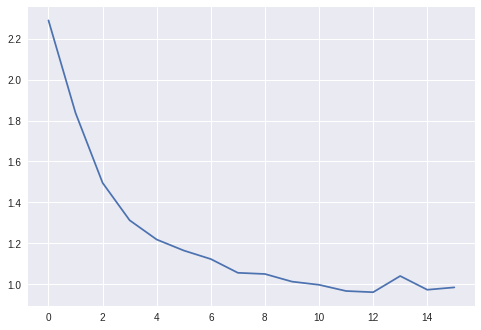

In [25]:
from keras import backend
from keras.callbacks import EarlyStopping

def embedding_input(name, n_in, n_out, reg):
    '''returns input and its embedding using Keras'''
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(input_dim=n_in, output_dim=n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

def rmse(y_true, y_pred):
    '''Define Root Mean Squared Error as a custom metric'''
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

#number of elements in embedding layer (latent factors)
n_factors=50

#get input and embedding for users and products
user_in, u = embedding_input('user_in', n_users, n_factors, 0.1)
prod_in, p = embedding_input('prod_in', n_prods, n_factors, 0.1)

#stop training when val_loss starts to increase
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=0)]

#model: concat embedding layers and feed to neural net
x = concatenate([u, p], axis=2)
x = Flatten()(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(10, activation='relu')(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(5, activation='relu')(x)
x = Dropout(0.8)(x)
x = BatchNormalization()(x)
x = Dense(1)(x)
nn = Model([user_in, prod_in], x)
nn.compile(optimizer=Adam(0.001), loss='mse', metrics=[rmse])

history = nn.fit([prod_ratings.user_id, prod_ratings.product_id], prod_ratings.product_score, batch_size=64,
       epochs=100, validation_split=0.2, verbose =1, callbacks=callbacks)
plt.plot(history.history['val_loss'])

In [26]:
nn.save_weights('models/nn5.h5')

In [ ]:
nn.load_weights('models/nn5.h5')

In [113]:
#prod id to prod name dictionary:
prod_id2name = pd.Series(prod_ratings.product_name.values, index=prod_ratings.product_id).to_dict()

def predictions_nn(u_id, p_id):
    '''create a product_name:product_score dictionary '''
    return (prod_id2name[p_id], nn.predict([np.array([u_id]), np.array([p_id])])[0][0])

def user_recommendation_nn(u_id):
    '''recommend 20 new products to user'''
    
    #exclude products the user has already bought
    prods_to_rate = list(set(prod_ratings.product_id) - set(prod_ratings[prod_ratings.user_id==u_id].product_id))
    
    #predict the ratings for new unseen products
    scores = {predictions_nn(u_id,p)[0]:predictions_nn(u_id,p)[1] for p in prods_to_rate}
    
    return list(OrderedDict(sorted(scores.items(), key =itemgetter(1), reverse = True)))[:20]

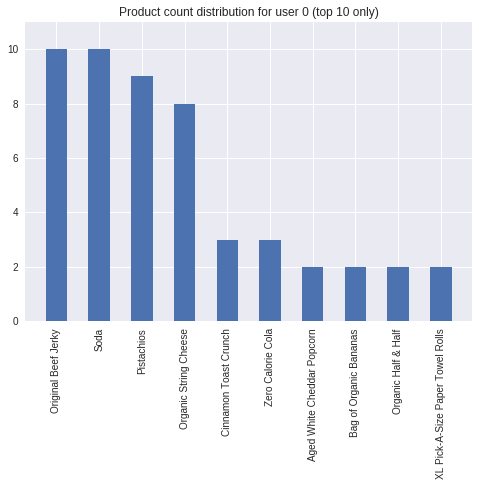

In [142]:
product_dist(0)

In [28]:
user_recommendation_nn(0)

['Organic Low Fat Cottage Cheese',
 'Honey Maid Graham Cracker Crumbs',
 'The Original Five Cheese Texas Toast',
 'Nacho Cheese Tortilla Chips',
 'Cheese Pizza Rolls',
 'Organic Cold Season Tea Bags',
 'Toasted Coconut Almondmilk Blend',
 'Roasted Pine Nut Hummus',
 'Honeycrisp Bag',
 'Junior Natur Medium Toothbrush',
 'Maca Powder',
 'Organic Carrot Bunch',
 'Organic Yams',
 'Chocolate Chip Cookie Dough Ice Cream',
 'Medium Cheddar Deli Sliced Cheese',
 'Organic Five Spice Tofu Nuggets',
 'Broccoli Florettes',
 'Gluten Free Whole Grain Bread',
 'Lowfat Peach Kefir Probiotic Cultured Milk Smoothie',
 'Organic Blueberry Waffles']

## Analyze results

For simplicity, we restrict the analysis to the top 2000 most popular products.

In [116]:
g_names=prod_ratings.groupby(['product_name'])['product_count'].sum()
g=prod_ratings.groupby(['product_id'])['product_count'].sum()

topProds_names = g_names.sort_values(ascending=False)[:2000]
topProds=g.sort_values(ascending=False)[:2000]
topProds = np.array(topProds.index)

list of top 10 products

In [118]:
topProds_names[:10]

product_name
Banana                    1252
Bag of Organic Bananas    1151
Organic Strawberries       883
Organic Hass Avocado       769
Organic Baby Spinach       727
Organic Avocado            526
Organic Raspberries        449
Limes                      422
Large Lemon                421
Organic Zucchini           412
Name: product_count, dtype: int64

Now we can look at the top and bottom rated products and their embeddings.

In [64]:
get_prod_emb = Model(prod_in, p)
prod_emb = np.squeeze(get_prod_emb.predict([topProds]))
prod_emb.shape

(2000, 50)

Because it's hard to interpret 50 embedding factors, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [68]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
prod_pca = pca.fit(prod_emb.T).components_

Here's the 1st component. Hard to tell what these features represent...

In [119]:
c0 = prod_pca[0]
prod_comp = [(c, prod_id2name[i]) for c,i in zip(c0, topProds)]

In [143]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10];

In [144]:
sorted(prod_comp, key=itemgetter(0))[:10];

Here's the 2nd component

In [122]:
c1 = prod_pca[1]
prod_comp = [(c, prod_id2name[i]) for c,i in zip(c1, topProds)]

In [145]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10];

In [146]:
sorted(prod_comp1, key=itemgetter(0))[:10];

Here's the 3rd component

In [128]:
c2 = prod_pca[2]
prod_comp = [(c, prod_id2name[i]) for c,i in zip(c2, topProds)]

In [147]:
sorted(prod_comp, key=itemgetter(0), reverse=True)[:10];

In [148]:
sorted(prod_comp, key=itemgetter(0))[:10];

We can draw a picture to see how various products appear on the map of these components. This picture shows the 1st and 3rd components.

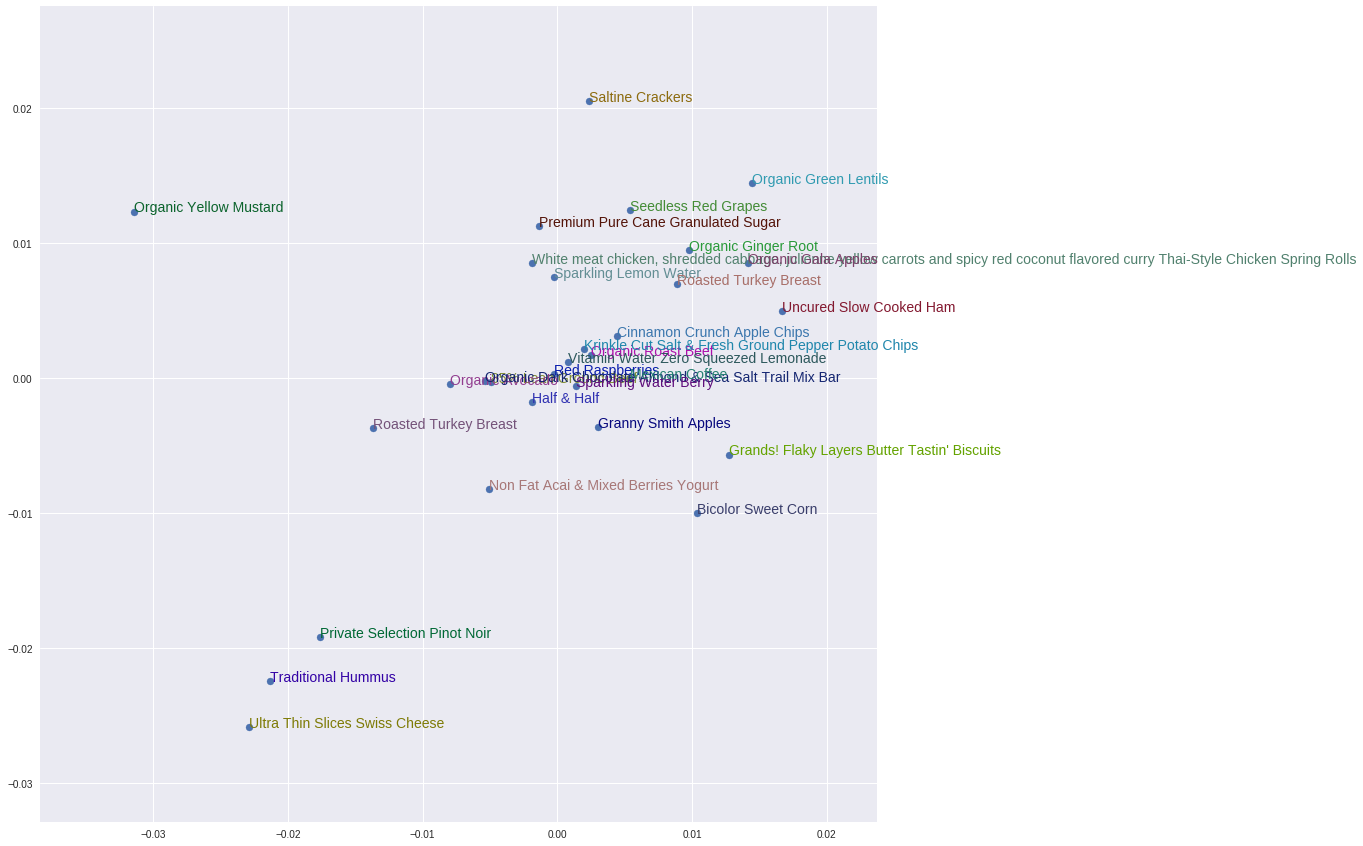

In [135]:
start=50; end=80
X = prod_pca[0][start:end]
Y = prod_pca[1][start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topProds[start:end], X, Y):
    plt.text(x,y,prod_names()[prod_ratings.product_id[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()